In [1]:
import collections
import functools
import itertools
import math
import os

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec, ticker
%matplotlib inline

import pandas as pd

import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette()

import scipy
from scipy.interpolate import interp1d

import statsmodels.api as sm

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

from IPython.display import Image

In [2]:
def read_data(filename):
    """ Reads in raw photoemission spectra and performs initial transformation
        and cleaning.
    """
    data = pd.read_csv(filename, sep='[\t,]+', header=None, engine='python',
                       na_values=['XXX.XXX'], names=['nm', 'QE'])

    if data.nm.min() < 10.:                    # energy rather than wavelength, needs conversion
        data['E'] = data.nm
        data['nm'] = 1240. / data.E            # conversion of energy to wavelength
    else:
        data['E'] = 1240. / data.nm            # conversion of wavelength to energy

    data['QE'] = data.QE.clip_lower(0.)        # remove negative elements
    data['QE3'] = np.power(data.QE, 1. / 3.)   # QE^(1/3) so we can use a linear fit

    return data

In [3]:
class LinearFit(object):

    def __init__(self, x, y, fit):
        self.x = x
        self.X = sm.add_constant(x)
        self.y = y
        self.fit = fit

        self.b = fit.params
        self.y_intercept, self.slope = fit.params
        self.x_intercept = -self.y_intercept / self.slope

        self.xm = np.mean(x)
        self.Sxx = np.sum(np.power(self.x - self.xm, 2))
        self.ym = np.mean(y)
        self.n = fit.nobs
        self.dof = fit.df_resid
        self.rsquared = fit.rsquared
        self.stddev = np.sqrt(fit.ssr / fit.df_resid)

    def yp(self, xp):
        """Calculates line over given x range."""
        return np.dot(sm.add_constant(xp), self.b)

    def tstar(self, alpha):
        """Statistical t-test for confidence intervals."""
        return scipy.stats.distributions.t.ppf(1.0 - alpha / 2.0, self.dof)

    def confidence_interval(self, xp=None, yp=None, alpha=0.05):
        """Calculates confidence interval for either x or y values."""
        if not (xp is None) ^ (yp is None):
            raise ValueError('Only one of [xp, yp] must be specified.')

        if xp is not None:
            return self._y_ci(xp, alpha=alpha)
        if yp is not None:
            return self._x_ci(yp, alpha=alpha)

    def prediction_interval(self, xp=None, yp=None, alpha=0.05):
        """Calculates prediction interval for either x or y values."""
        if not (xp is None) ^ (yp is None):
            raise ValueError('Only one of [xp, yp] must be specified.')

        if xp is not None:
            return self._y_pi(xp, alpha=alpha)
        if yp is not None:
            return self._x_pi(yp, alpha=alpha)

    def plot_fit(self, xp, axis, alpha=0.05, ci=True):
        """Plots the fit over given x range."""
        yp = self.yp(xp)

        if ci:
            ci = self.confidence_interval(xp, alpha=alpha)
            pi = self.prediction_interval(xp, alpha=alpha)
            axis.fill_between(xp, yp - pi, yp + pi, color='k', alpha=0.1)
            axis.fill_between(xp, yp - ci, yp + ci, color='k', alpha=0.2)
        axis.plot(xp, yp, c='k', ls=':')

    def _y_ci(self, xp, alpha=0.05):
        return (self.tstar(alpha) * self.stddev
                * np.sqrt((1. / self.n) + (np.power(xp - self.xm, 2) / self.Sxx)))

    def _y_pi(self, xp, alpha=0.05):
        return (self.tstar(alpha) * self.stddev
                * np.sqrt(1. + (1. / self.n) + (np.power(xp - self.xm, 2) / self.Sxx)))

    def _x_ci(self, yp, alpha=0.05):
        """Inverse regression, after Sec 3.2 from Draper & Smith 1998."""
        xp = (yp - self.b[0]) / self.b[1]
        dx = xp - self.xm
        ts = self.tstar(alpha) * self.stddev
        b1 = self.b[1]
        g = (ts / b1) ** 2 / self.Sxx

        left = dx * g
        denom = (1. - g)
        right = (ts / b1) * np.sqrt(dx ** 2 / self.Sxx + denom / self.n)

        return np.array([(left - right) / denom, (left + right) / denom])

    def _x_pi(self, yp, alpha=0.05):
        """Inverse regression, after Sec 3.2 from Draper & Smith 1998."""
        xp = (yp - self.b[0]) / self.b[1]
        dx = xp - self.xm
        ts = self.tstar(alpha) * self.stddev
        b1 = self.b[1]
        g = (ts / b1) ** 2 / self.Sxx

        left = dx * g
        denom = (1. - g)
        right = (ts / b1) * np.sqrt(dx ** 2 / self.Sxx + denom / self.n + denom)

        return np.array([(left - right) / denom, (left + right) / denom])

In [4]:
def find_linear(df, window_length=15):
    """ Fits linear portion of spectra using a rolling mean of `window_length`
        and takes the n best fits as candidates.
    """
    if window_length % 2 == 0:
        raise ValueError('The window must be odd')
    if window_length < 5:
        raise ValueError('The window must be at least 5')

    stats = {
        'i': [],
        'slope': [],
        'threshold': [],
        'r2': [],
        'stddev': [],
    }
    fits = []

    n = (window_length - 1) // 2
    for mid in range(n, len(df) - n):
        low, high = mid - n, mid + n + 1
        window = df.iloc[low:high]

        x = window.E.values
        X = sm.add_constant(x)
        y = window.QE3.values

        model = sm.OLS(y, X)
        results = model.fit()

        fit = LinearFit(x, y, results)

        fits.append(fit)
        stats['i'].append(mid)
        stats['slope'].append(fit.slope)
        stats['threshold'].append(fit.x_intercept)
        stats['r2'].append(fit.rsquared)
        stats['stddev'].append(fit.stddev)

    stats = pd.DataFrame(stats)

    # we are looking for the line with
    #   a) the highest R^2
    #   b) the highest slope

    max_slope = stats.slope.max()
    stats['best'] = stats.r2 + stats.slope / max_slope
    maxima = scipy.signal.argrelmax(stats.best.values)[0]
    best_fit = stats.iloc[maxima].best.idxmax()

    return fits[best_fit]

# Read data

In [5]:
data_folder = '../data/raw/'

In [6]:
data = {'s': [], 't': [], 'e': [], 'q': []}
skip = ['s0492d', 'g2037']
for subdir, dirs, files in os.walk(data_folder):
    for file in files:
        if '_' not in file:
            continue
        try:
            sample = os.path.splitext(file)[0].split('_')[1]
        except:
            print('Error: {}'.format(file))
            continue
    
        if sample in skip:
            print('{}: skipping'.format(sample))
            continue

        filename = os.path.join(data_folder, file)
        df = read_data(filename)
        f = find_linear(df, window_length=11)
        print('{}: {:.4} +- {}'.format(sample, f.x_intercept, f.prediction_interval(yp=0)))
        data['s'].append(sample)
        data['t'].append(f.x_intercept)
        data['e'].append(list(np.abs(f.prediction_interval(yp=0))[::-1]))
        data['q'].append(df.QE.max())

df = pd.DataFrame(data)

g2919pc: 4.103 +- [-0.01159584  0.01129819]
g2278na: 3.414 +- [-0.00598498  0.00587423]
g3133ap: 4.674 +- [-0.01434999  0.01391563]
s0490c: 4.577 +- [-0.01256563  0.01223131]
s0550b: 4.388 +- [-0.00940885  0.00920125]
s0478b: 4.2 +- [-0.00599268  0.00590718]


/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1181: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


s0573b: 4.06 +- [-0.01475953  0.01435232]
g2938: 4.286 +- [-0.02355094  0.02233867]
g2227a: 3.752 +- [-0.02907255  0.02704029]
g2993pc: 4.09 +- [-0.00877658  0.00864204]
g3017ap: 3.597 +- [-0.02134187  0.0206877 ]
g3024: 4.302 +- [-0.0150654   0.01451532]
s0572b: 3.827 +- [-0.04871865  0.04491846]
s0508a: 4.224 +- [-0.0282407   0.02699379]
s0352a: 4.414 +- [-0.04297455  0.04012069]
g2037: skipping
Z041014B: 4.328 +- [-0.0081539   0.00801847]
s0492a: 4.558 +- [-0.01490795  0.01445349]
g3025: 4.149 +- [-0.02154103  0.02060132]
s0477b: 4.461 +- [-0.00862857  0.00845552]
g3179pc3: 4.81 +- [-0.04379983  0.04038871]
g3270-1: 4.854 +- [-0.0232074   0.02217733]
g3267-1c: 3.056 +- [-0.02330043  0.02132311]
s0508b: 2.929 +- [ 0.98191312  0.20384431]
g3179pc1: 4.773 +- [-0.04147104  0.0383526 ]
s0571b: 4.678 +- [-0.03399514  0.03187139]
s490b: 4.235 +- [-0.00614471  0.00605326]
s0506b: 4.643 +- [-0.01526805  0.01479278]
g2968pc: 4.247 +- [-0.01371539  0.01327806]
t1748: 4.63 +- [-0.01203344  0.01

# Various transformations

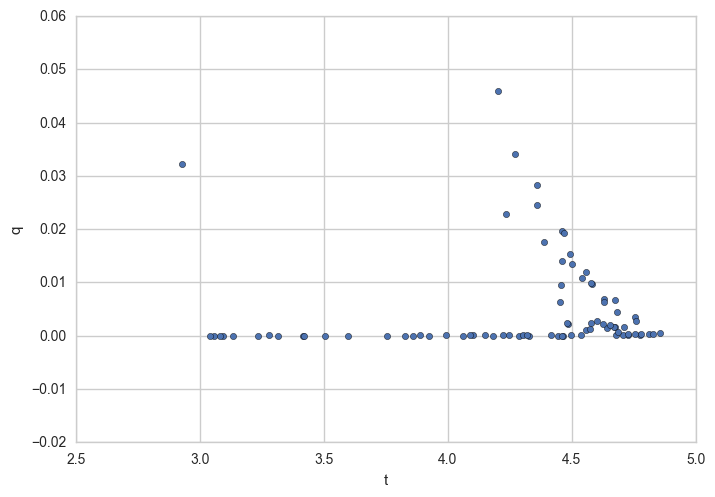

In [7]:
df.plot(x='t', y='q', kind='scatter')

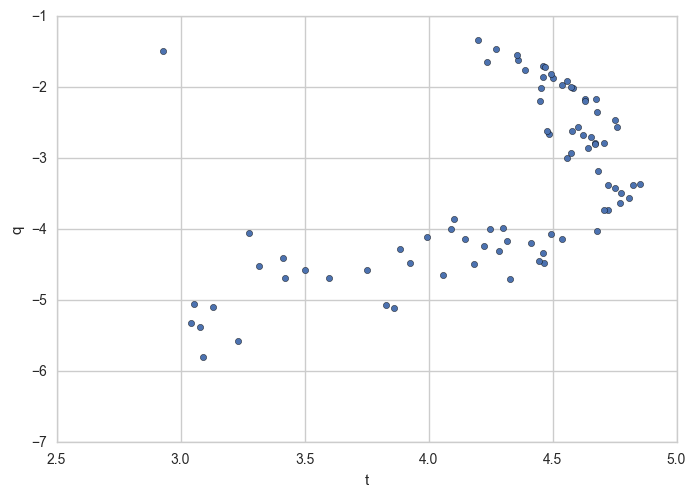

In [8]:
df2 = df[['t']].copy()
df2['q'] = np.log10(df.q)

df2.plot(x='t', y='q', kind='scatter')

# Errorbars

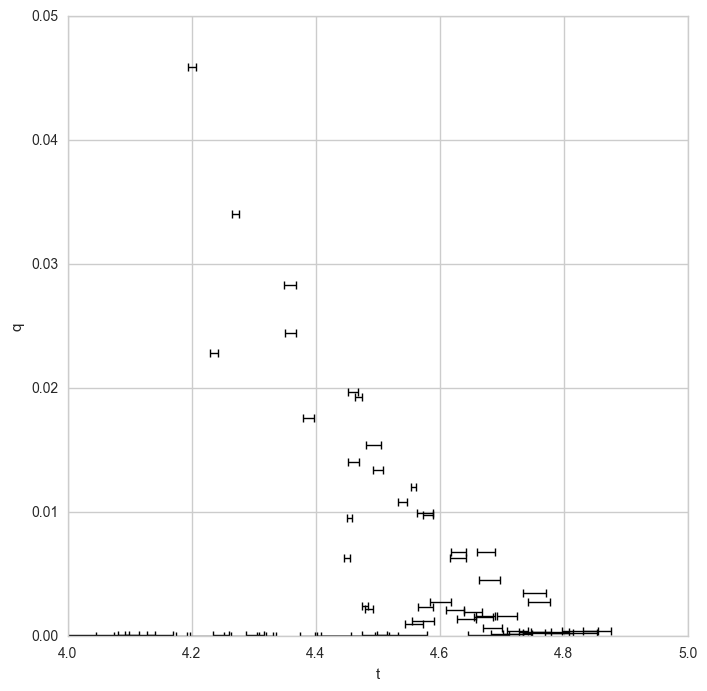

In [9]:
err = np.array(list(df.e)).T

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.errorbar(df.t, df.q, xerr=err, fmt='none', ecolor='k', capthick=1, elinewidth=1)
df2.plot(x='t', y='q', kind='scatter', xlim=(4, 5), ylim=(0, 0.05), c='k', ax=ax)

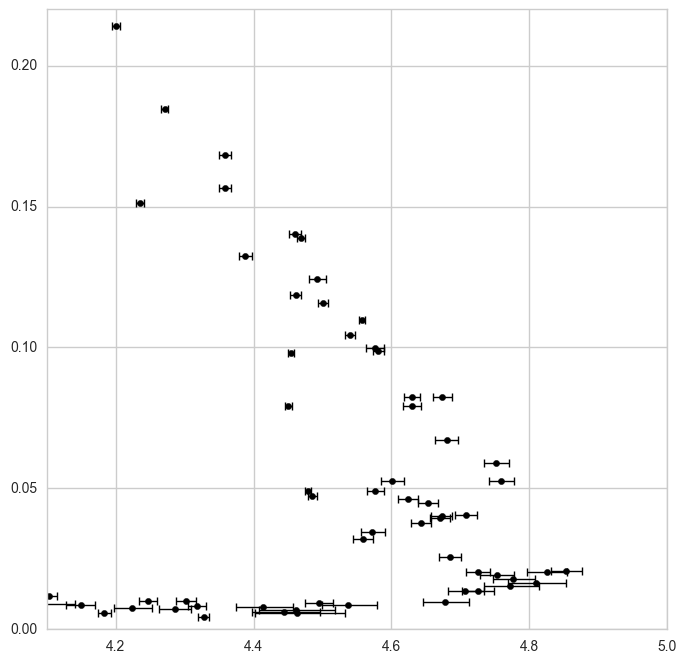

In [10]:
x = df.t.values
y = np.sqrt(df.q.values)

xerr = np.array(list(df.e)).T

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.errorbar(x, y, xerr=xerr, fmt='none', ecolor='k', capthick=1, elinewidth=1)
ax.scatter(x, y, c='k')

ax.set_xlim(4.1, 5)
ax.set_ylim(0, 0.22)

plt.show()